<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Выводы" data-toc-modified-id="Выводы-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Выводы</a></span></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Выводы" data-toc-modified-id="Выводы-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Выводы</a></span></li></ul></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

В нашем распоряжении набор данных с разметкой о токсичности правок. Обучим на них разные модели и выберем одну с наилучшим значение F1-меры, причем ее значение должно быть не меньше 0.75.

**Цель исследования**: построить модель для классификации комментариев на позитивные и негативные.

**Ход исследования**

Данные для исследования получим из файла `toxic_comments.csv`. Перед обучением моделей необходимо будет проанализировать и подготовить данные.

Таким образом, исследование пройдет в два этапа:
1. Анализ и подготовка данных.
2. Обучение и тестирование моделей.

## Подготовка данных

Для начала импортируем необходимые в работе библиотеки.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
import re 
import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Прочитаем файл `toxic_comments.csv` из каталога `datasets` и сохраним его в переменной `data`.

In [2]:
data = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)

Составим первое впечатление о данных:
1. Получим общую информацию методом `info()`.
2. Выведем на экран пять строк таблицы методом `sample()`. 
3. Оценим разброс значений методом `describe()`.

In [3]:
data.info()
display(data.sample(5))
display(data.describe(include='all'))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


,text,toxic
113681,Merge discussion for Sol Biderman Collection \...,0
116981,"""\n\n Sentry Gun Page \n\nCLEARLY links to com...",0
124317,Hear the voices in my head. I swear to God it ...,0
11032,Donald Goerke was the inventor. He recently pa...,0
127885,"""\n\nTo Hersfold, what you asserted in your re...",0


,text,toxic
count,159292,159292.000000
unique,159292,NaN
top,"""\n Your request at Files for upload \n Commen...",NaN
freq,1,NaN
mean,NaN,0.101612
std,NaN,0.302139
min,NaN,0.000000
25%,NaN,0.000000
50%,NaN,0.000000
75%,NaN,0.000000


Таблица состоит из двух признаков:
* text - текст комментария;
* toxic - признак токсичного комментария.

Проверим классы на сбалансированность. Если доля объектов одного класса окажется слишком низкой, а другого — слишком большой, то возможен «перекос» в сторону мажоритарного класса, т.е. с большей вероятностью новые наблюдения модель обучения будет относить к преобладающему классу.

0    0.898388
1    0.101612
Name: toxic, dtype: float64


<AxesSubplot:>

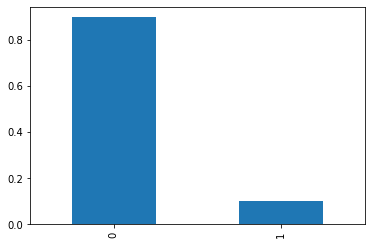

In [4]:
print(data['toxic'].value_counts(normalize=True))
data['toxic'].value_counts(normalize=True).plot(kind='bar')

Соотношение токсичных комментариев к обычным 9:1, не забудем учесть дисбаланс классов при обучении моделей.

Упростим текст путем лемматизации слов. Создадим функцию лемматизации `lemmatize()` и функцию `get_wordnet_pos()` для получения POS-тега слова.

In [5]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize(data):
    lemmatizer = WordNetLemmatizer()
    word_list = nltk.word_tokenize(data['text'])
    return ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in word_list])

Вызовем функцию лемматизации на нашем датасете, преобразованные тексты сохраним в признаке `text_lemma`.

In [6]:
%%time
data['text_lemma'] = data.apply(lemmatize, axis=1)

CPU times: user 18min 20s, sys: 1min 52s, total: 20min 12s
Wall time: 20min 12s


От лишних символов текст очистят регулярные выражения. Напишем функцию `clear_text()`, которая оставит в тексте только латинские символы и пробелы.

In [7]:
def clear_text(data):
    return " ".join(re.sub(r'[^a-zA-Z]', ' ', data['text_lemma'].lower()).split())

data['text_lemma'] = data.apply(clear_text, axis=1)

Загрузим английские стоп-слова функцией `stopwords.words()` и избавимся от них в датасете.

In [8]:
stop_words = set(stopwords.words('english'))

data['text_lemma'] = data['text_lemma'].apply(lambda x: 
                                              ' '.join([word for word in x.split() 
                                                       if word not in (stop_words)]))

Проверим, качество преобразования комментариев: выведем на экран выборочные строки таблицы функцией `sample()`.

In [9]:
data.sample(10)[['text', 'text_lemma']]

,text,text_lemma
65047,"""\nWell this is what is going to happen soon. ...",well go happen soon time page unfrozen heard t...
132717,"Welcome!\n\nHello, , and welcome to Wikipedia!...",welcome hello welcome wikipedia thank contribu...
2116,Thank you! I took an extended Wiki-break recen...,thank take extend wiki break recently nice rec...
64029,"""\n\nPlease stop. If you continue to vandalize...",please stop continue vandalize page block edit...
28818,"""\n\n Media protraying vandalism to wiki artic...",media protraying vandalism wiki article attack...
97231,"""\n\n Credit? \n\nHello. You put 2011 Colombia...",credit hello put colombian floods front page n...
142716,Weight sounds fishy\n\n>Mk-54 weighed 68 kilog...,weight sound fishy mk weigh kilogram sixty eig...
72824,Regardless. Dont ever touch my user page again...,regardless dont ever touch user page get mgiht...
43925,"""The """"conclusions"""" section was blatantly POV...",conclusion section blatantly pov like essay en...
27939,I just wanted to let you know that you legitim...,want let know legitimately make laugh loud who...


Поделим исходный набор данных на обучающую и тестовую выборки в отношении 3:1 с помощью метода `train_test_split()`.

In [10]:
train, test = train_test_split(data, stratify=data['toxic'], test_size=0.25)

train_features = train['text_lemma']
train_target = train['toxic']
test_features = test['text_lemma']
test_target = test['toxic']

Проверим размеры полученных выборок функцией `shape`.

In [11]:
print(train_features.shape, test_features.shape)

(119469,) (39823,)


### Выводы

На этапе подготовки данных была проведена лемматизация слов комментариев, исключены лишние символы и знаки, удалены стоп-слова. Данные были поделены на обучающую и тестовую выборку в отношении 3:1.

Теперь можно переходить к обучению и тестированию моделей.

## Обучение моделей

Для решения задачи классификации будем использовать три модели:
* логистическая регрессия;
* случайный лес;
* градиентный бустинг.

Подберем лучшие гиперпараметры для модели логистической регрессии на обучающей выборке с помощью функции `GridSearchCV()`

In [12]:
%%time
pipe_logreg = Pipeline(
    [
        ("vect", CountVectorizer()),
        ("tfidf", TfidfTransformer()),
        ("clf", LogisticRegression(random_state=12345, 
                                   solver='liblinear',
                                   class_weight='balanced'))
    ]
)

param_grid = {
    'clf__C': np.logspace(-2,2,5), 
    'clf__penalty': ['l1', 'l2']
}

clf = (GridSearchCV(pipe_logreg, param_grid, cv=4, scoring='f1'))
best_logreg_model = clf.fit(train_features, train_target)
print(f'Лучшие параметры модели на валидации: {best_logreg_model.best_params_}')
print(f'F1 лучшей модели на валидации: {best_logreg_model.best_score_}')

Лучшие параметры модели на валидации: {'clf__C': 10.0, 'clf__penalty': 'l2'}
F1 лучшей модели на валидации: 0.7572934281680689
CPU times: user 6min 45s, sys: 3min 28s, total: 10min 14s
Wall time: 10min 14s


Определим лучшую модель случайного леса с помощью кросс-валидации, изменяя значения гиперпараметра `max_depth`.

In [13]:
%%time
pipe_rforclass = Pipeline(
    [
        ("vect", CountVectorizer()),
        ("tfidf", TfidfTransformer()),
        ("clf", RandomForestClassifier(random_state=12345, 
                                       class_weight='balanced'))
    ]
)

param_grid = {
    'clf__max_depth': [100, 200, 300]
}

clf = (GridSearchCV(pipe_rforclass, param_grid, cv=4, scoring='f1'))
best_rforclass_model = clf.fit(train_features, train_target)
print(f'Лучшие параметры модели на валидации: {best_rforclass_model.best_params_}')
print(f'F1 лучшей модели на валидации: {best_rforclass_model.best_score_}')

Лучшие параметры модели на валидации: {'clf__max_depth': 300}
F1 лучшей модели на валидации: 0.6026338530574401
CPU times: user 44min 2s, sys: 4.64 s, total: 44min 7s
Wall time: 44min 8s


Перейдем к обучению модели градиентного бустинга SGDClassifier.

In [14]:
%%time
pipe_sgdc = Pipeline(
    [
        ("vect", CountVectorizer()),
        ("tfidf", TfidfTransformer()),
        ("clf", SGDClassifier(random_state=12345,
                              class_weight='balanced'))
    ]
)

param_grid = {
    "clf__alpha": (0.00001, 0.000001),
    "clf__penalty": ("l2", "elasticnet")
}

clf = (GridSearchCV(pipe_sgdc, param_grid, cv=4, scoring='f1'))
best_sgdc_model = clf.fit(train_features, train_target)
print(f'Лучшие параметры модели на валидации: {best_sgdc_model.best_params_}')
print(f'F1 лучшей модели на валидации: {best_sgdc_model.best_score_}')

Лучшие параметры модели на валидации: {'clf__alpha': 1e-05, 'clf__penalty': 'l2'}
F1 лучшей модели на валидации: 0.7409708019988527
CPU times: user 1min 14s, sys: 1.74 s, total: 1min 16s
Wall time: 1min 16s


Лучшее качество на валидации показала модель логистической регрессии с l2-регуляризацией. Преобразуем тексты тестовой выборки в векторы и проверим качество обученной модели, определив значение F1 меры.

In [15]:
test_features = best_logreg_model.best_estimator_['vect'].transform(test_features)
test_features = best_logreg_model.best_estimator_['tfidf'].transform(test_features)
prediction =  best_logreg_model.best_estimator_['clf'].predict(test_features)
print("F1:", round(f1_score(test_target, prediction), 2))

F1: 0.76


### Выводы

В качестве моделей обучения были выбраны логистическая регрессия, случайный лес и градиентный бустинг. Изменяя значения гиперпараметров мы смогли достичь на валидационной выборке лучшего значения F1-меры. 

Лучшее качество показала модель логистической регрессии с l2-регуляризацией. Значение гармонического среднего между точностью и полнотой на тестовой выборке составило 0.76.

## Общий вывод

На основе данных о комментариях пользователей было проведено обучение трех моделей: логистическая регрессия, случайный лес и градиентный бустинг для относения комментария к категории "токсичные". Для каждой модели были определены гиперпараметры, позволяющие добиться лучшего значения F1-меры.

Наилучшее качество на валидации показала модель логистической регрессии со значениями гиперпараметров C = 10.0 и penalty = "l2". На тестовой выборке модель обучения достигла значения метрики F1 = 0.76, что удовлетворяет условиям исследования.

Таким образом, выбирая модель машинного обучения для решения задачи исследования, особое внимание следует обратить на модель логистической регрессии.